In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
class CardiacPatient:
    """Class representing an individual patient's cardiac data"""
    
    def __init__(self, diagnosis_id, visit_id, disease_type, severity, symptoms, lab_results):
        self.diagnosis_id = diagnosis_id
        self.visit_id = visit_id
        self.disease_type = disease_type
        self.severity = severity
        self.symptoms = [s.strip().lower() for s in symptoms.split(',')]
        self.lab_results = lab_results
        
    def get_key_metrics(self):
        """Return the most clinically relevant metrics"""
        return {
            'troponin': self.lab_results.get('troponin_level'),
            'crp': self.lab_results.get('crp_level'),
            'hba1c': self.lab_results.get('hba1c'),
            'ldl': self.lab_results.get('ldl_cholesterol')
        }
        
    def is_high_risk(self):
        """Determine if patient is high risk based on lab values"""
        return (self.lab_results.get('troponin_level', 0) > 0.4 or 
                self.lab_results.get('crp_level', 0) > 5)

class CardiacDataset:
    """Class representing the entire dataset of cardiac patients"""
    
    def __init__(self, filepath):
        self.filepath = filepath
        self.patients = []
        self._load_data()
        
    def _load_data(self):
        """Load and parse the CSV data into Patient objects"""
        df = pd.read_csv(self.filepath)
        
        # Convert severity to ordered categorical
        df['severity'] = pd.Categorical(
            df['severity'], 
            categories=['Mild', 'Moderate', 'Severe'], 
            ordered=True
        )
        
        # Create Patient objects for each row
        for _, row in df.iterrows():
            lab_results = {
                'ldl_cholesterol': row['ldl_cholesterol'],
                'hdl_cholesterol': row['hdl_cholesterol'],
                'triglycerides': row['triglycerides'],
                'troponin_level': row['troponin_level'],
                'crp_level': row['crp_level'],
                'hba1c': row['hba1c'],
                'platelet_count': row['platelet_count'],
                'wbc': row['wbc']
            }
            
            patient = CardiacPatient(
                row['diagnosis_id'],
                row['visit_id'],
                row['disease_type'],
                row['severity'],
                row['symptoms'],
                lab_results
            )
            
            self.patients.append(patient)
    
    def get_patients_by_condition(self, condition):
        """Filter patients by specific condition"""
        return [p for p in self.patients if p.disease_type == condition]
    
    def get_high_risk_patients(self):
        """Get all high risk patients"""
        return [p for p in self.patients if p.is_high_risk()]
    
    def get_disease_counts(self):
        """Count occurrences of each disease type"""
        counts = {}
        for p in self.patients:
            if p.disease_type in counts:
                counts[p.disease_type] += 1
            else:
                counts[p.disease_type] = 1
        return counts
    
    def get_symptom_counts(self):
        """Count occurrences of each symptom"""
        symptom_counts = {}
        for p in self.patients:
            for symptom in p.symptoms:
                if symptom in symptom_counts:
                    symptom_counts[symptom] += 1
                else:
                    symptom_counts[symptom] = 1
        return symptom_counts

class CardiacAnalyzer:
    """Class for analyzing and visualizing cardiac data"""
    
    def __init__(self, dataset):
        self.dataset = dataset
        self._prepare_dataframe()
        
    def _prepare_dataframe(self):
        """Convert patient objects to DataFrame for analysis"""
        data = []
        for p in self.dataset.patients:
            row = {
                'diagnosis_id': p.diagnosis_id,
                'visit_id': p.visit_id,
                'disease_type': p.disease_type,
                'severity': p.severity,
                'symptoms': ', '.join(p.symptoms),
                **p.lab_results
            }
            data.append(row)
        self.df = pd.DataFrame(data)
        
    def plot_disease_distribution(self):
        """Plot distribution of disease types"""
        counts = self.dataset.get_disease_counts()
        diseases = list(counts.keys())
        values = list(counts.values())
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=values, y=diseases, order=sorted(diseases, key=lambda x: -counts[x]))
        plt.title('Distribution of Disease Types')
        plt.xlabel('Count')
        plt.ylabel('Disease Type')
        plt.show()
        
    def plot_severity_distribution(self):
        """Plot severity distribution by disease type"""
        plt.figure(figsize=(12, 6))
        sns.countplot(data=self.df, x='disease_type', hue='severity')
        plt.title('Severity Distribution by Disease Type')
        plt.xlabel('Disease Type')
        plt.ylabel('Count')
        plt.legend(title='Severity')
        plt.xticks(rotation=45)
        plt.show()
    
    def plot_lab_correlations(self):
        """Plot correlation matrix of lab results"""
        lab_columns = [
            'ldl_cholesterol', 'hdl_cholesterol', 'triglycerides', 
            'troponin_level', 'crp_level', 'hba1c', 'platelet_count', 'wbc'
        ]
        corr_matrix = self.df[lab_columns].corr()
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix of Lab Results')
        plt.show()
    
    def plot_key_metrics(self):
        """Plot key lab metrics by disease type and severity"""
        plt.figure(figsize=(15, 10))
        
        metrics = [
            ('troponin_level', 'Troponin Levels'),
            ('crp_level', 'CRP Levels'), 
            ('hba1c', 'HbA1c Levels'),
            ('ldl_cholesterol', 'LDL Cholesterol')
        ]
        
        for i, (col, title) in enumerate(metrics, 1):
            plt.subplot(2, 2, i)
            sns.boxplot(
                data=self.df, 
                x='disease_type', 
                y=col, 
                hue='severity'
            )
            plt.title(f'{title} by Disease and Severity')
            plt.xticks(rotation=45)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
    
    def analyze_symptoms(self):
        """Analyze and plot symptom frequencies"""
        symptom_counts = self.dataset.get_symptom_counts()
        
        # Sort symptoms by frequency
        sorted_symptoms = sorted(symptom_counts.items(), key=lambda x: x[1])
        symptoms = [s[0] for s in sorted_symptoms]
        counts = [s[1] for s in sorted_symptoms]
        
        plt.figure(figsize=(10, 6))
        plt.barh(symptoms, counts)
        plt.title('Most Common Symptoms')
        plt.xlabel('Frequency')
        plt.ylabel('Symptom')
        plt.show()
        
        return symptom_counts
    
    def basic_stats(self, column):
        """Calculate basic statistics for a lab column"""
        if column not in self.df.columns:
            return None
            
        return {
            'mean': np.mean(self.df[column]),
            'median': np.median(self.df[column]),
            'std': np.std(self.df[column]),
            'min': np.min(self.df[column]),
            'max': np.max(self.df[column])
        }

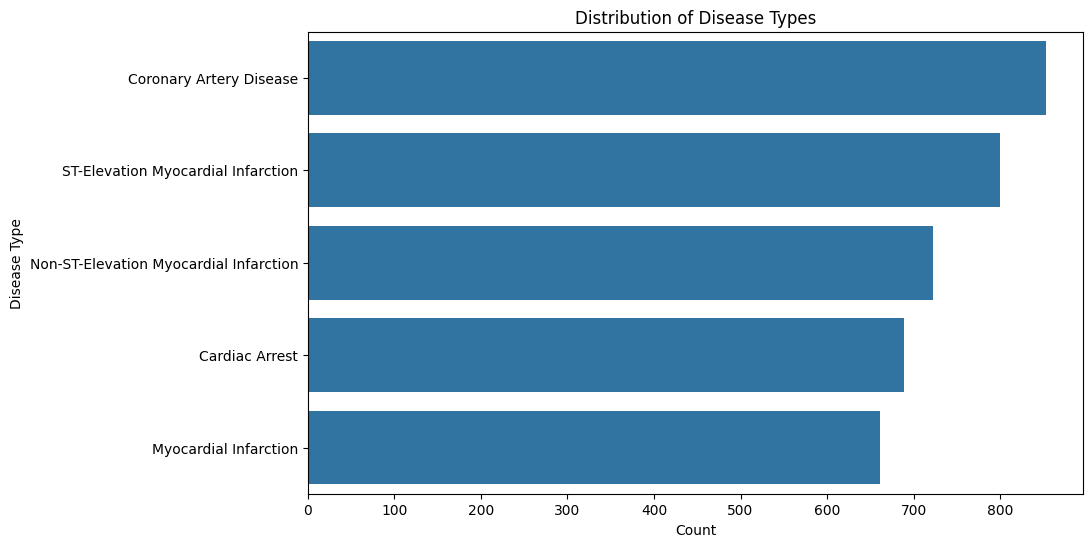

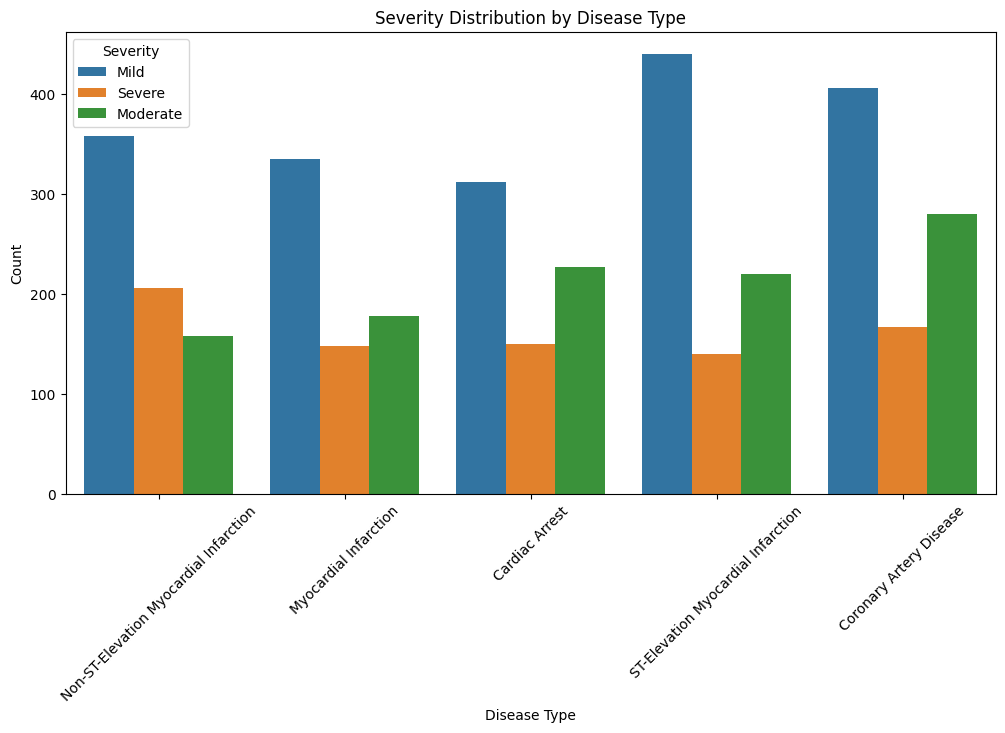

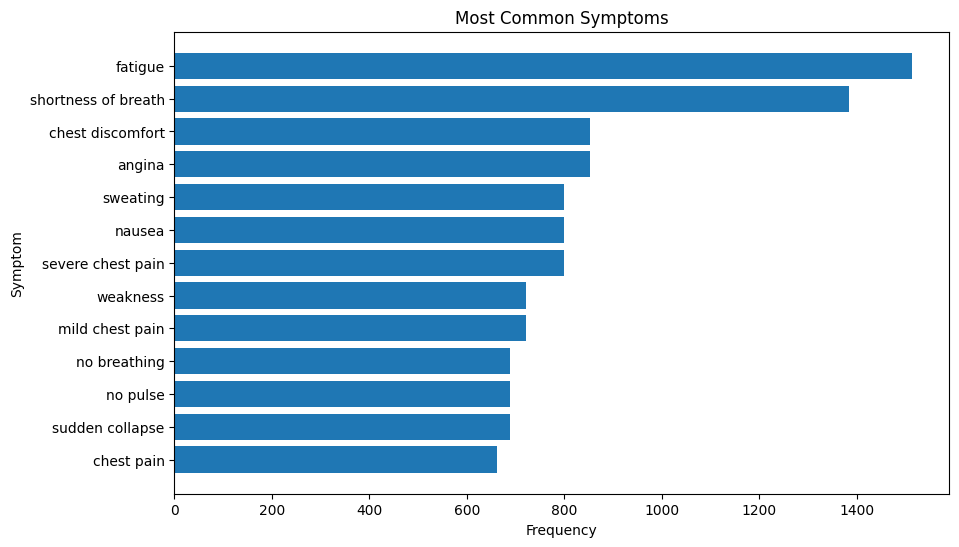


Top 5 Symptoms:
fatigue: 1514
shortness of breath: 1383
angina: 853
chest discomfort: 853
severe chest pain: 800


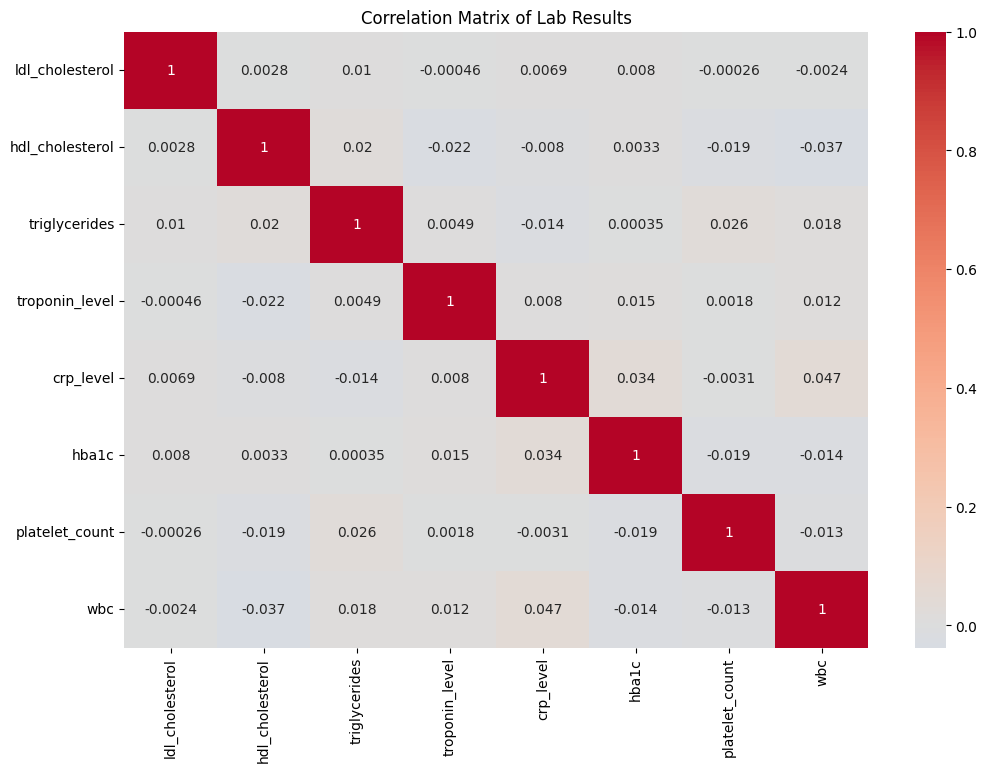

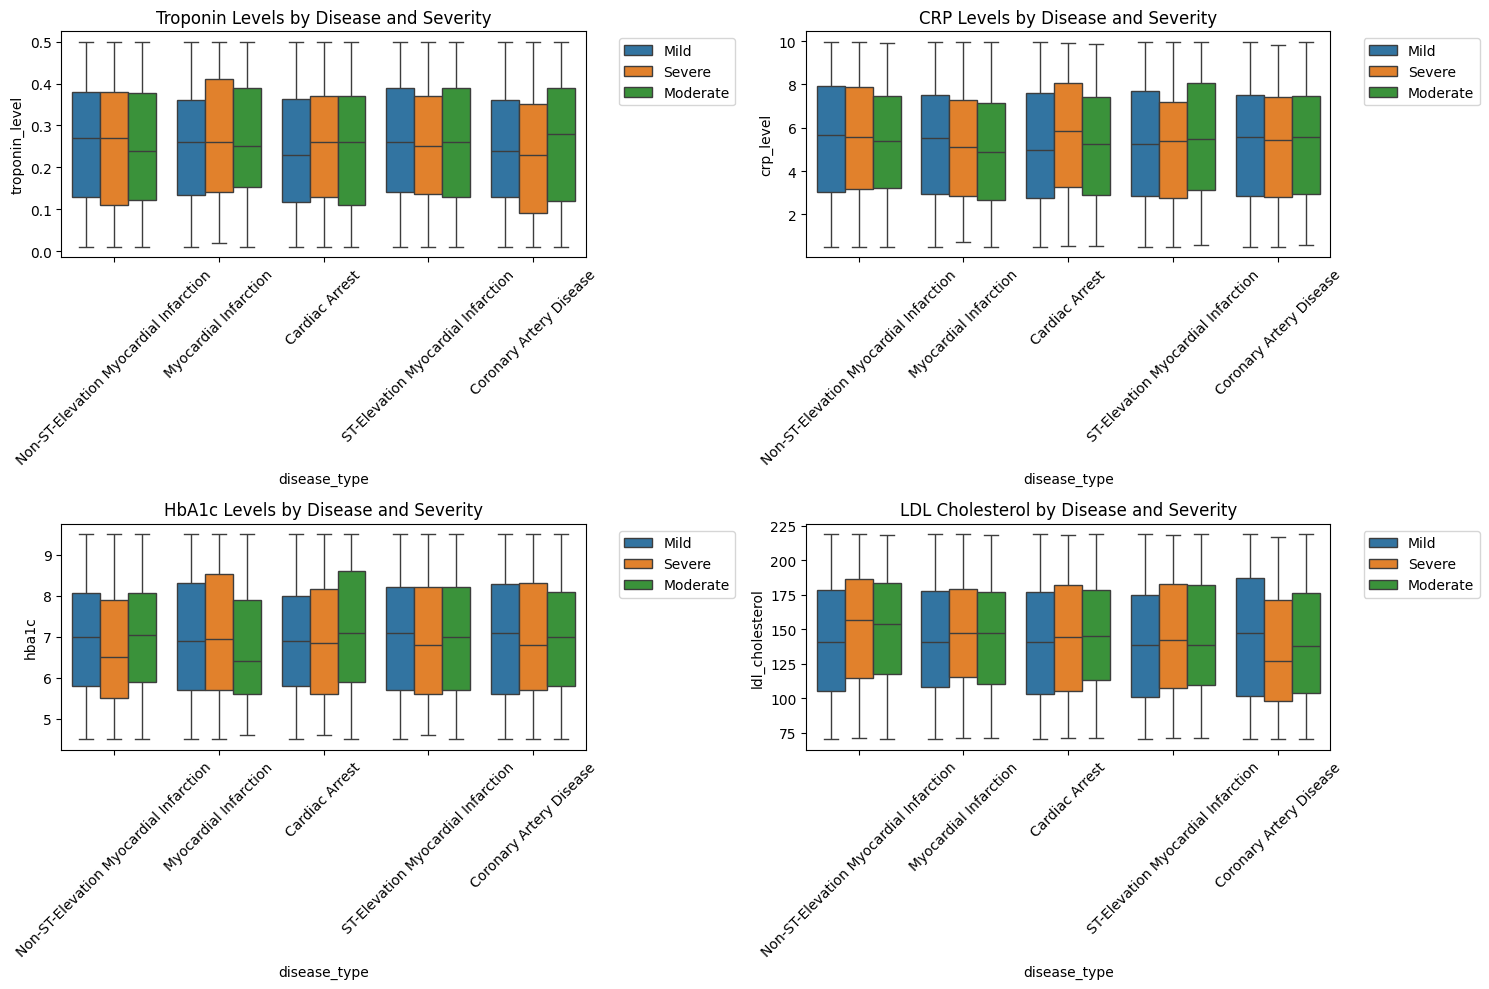


Number of high risk patients: 2313

Troponin Statistics:
mean: 0.25
median: 0.25
std: 0.14
min: 0.01
max: 0.50


In [6]:
if __name__ == "__main__":
    # Load the dataset
    dataset = CardiacDataset('diagnoses+lab_results.csv')
    
    # Create analyzer
    analyzer = CardiacAnalyzer(dataset)
    
    # Show basic disease distribution
    analyzer.plot_disease_distribution()
    
    # Show severity distribution
    analyzer.plot_severity_distribution()
    
    # Analyze symptoms
    symptom_counts = analyzer.analyze_symptoms()
    print("\nTop 5 Symptoms:")
    for symptom, count in sorted(symptom_counts.items(), key=lambda x: -x[1])[:5]:
        print(f"{symptom}: {count}")
    
    # Show lab correlations
    analyzer.plot_lab_correlations()
    
    # Show key metrics
    analyzer.plot_key_metrics()
    
    # Get high risk patients
    high_risk = dataset.get_high_risk_patients()
    print(f"\nNumber of high risk patients: {len(high_risk)}")
    
    # Get basic stats for troponin
    troponin_stats = analyzer.basic_stats('troponin_level')
    print("\nTroponin Statistics:")
    for stat, value in troponin_stats.items():
        print(f"{stat}: {value:.2f}")